In [2]:
# Indeed UK Job Scraper

In [3]:
# Importing libraries

import csv
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime 

In [4]:
# The job listing website Indeed UK is static and thus, makes it technically "easy" to scrape data from. 
# They also follow a standardized format : https://uk.indeed.com/jobs? + 'q=role'&l'=location'.

def get_url(role, location):
    '''Generating a URL from role and location'''
    template = 'https://uk.indeed.com/jobs?q={}&l={}'
    url = template.format(role, location)
    return url

In [5]:
# Assigning the get_url function to the url variable and 
# passing the desired role and location.

url = get_url('data analyst', 'edinburgh')

In [6]:
# Let's now extract the raw html

response = requests.get(url)

In [7]:
#Checking the status code : OK for 200.

response

<Response [200]>

In [8]:
# Parsing to create a soup object to then retrieve the desired text information.

soup = BeautifulSoup(response.text, 'html.parser')

In [9]:
# Using the page document inspector to find the unique class or id
# for the information that I want to extract.

# Starting with the job cards.

cards = soup.find_all('div','job_seen_beacon')

In [10]:
# There are 15 posts per page, so it matches the count of the cards variable.

len(cards)

15

In [11]:
# Let's now define the extraction of the different characteristics for a single job 
# to then apply the model to the entire record set.

card = cards[0]

In [12]:
# Extracting the job title. Let's use tag names to navigate the tree structure.

job_title = card.find('h2', class_='jobTitle').text.strip('new')


In [13]:
# Extracting the company name

company = card.find('span', 'companyName').text.strip()

In [14]:
# Extracting the location. This field will require some post scraped cleaning as it may include the work structure (e.g. remote, on-site, etc.)

job_location = card.find('div', 'companyLocation').text.strip()

In [15]:
# I'll use today's date from the datetime library to keep track of when each record was extracted

today = datetime.today().strftime('%Y-%m-%d')

In [16]:
# Extracting the job summary

job_summary = card.find('div', 'job-snippet').text.strip().replace('\n','')

In [17]:
# Extracting the salary, if shown. To prevent this from returning an error when the salary is not shown,
# I will this up in a try and except

try:
    job_salary = card.find('div', 'salary-snippet').text.strip()
except:
    job_salary = ''

In [18]:
# Once the model for the first has been created, I will now generalize this model by using a function

def get_info(card):
    '''Extract job information from a single record'''
    job_title = card.find('h2', class_='jobTitle').text.strip('new')
    company = card.find('span', 'companyName').text.strip()
    job_location = card.find('div', 'companyLocation').text.strip()
    today = datetime.today().strftime('%Y-%m-%d')
    job_summary = card.find('div', 'job-snippet').text.strip().replace('\n','')
    try:
        job_salary = card.find('div', 'salary-snippet').text.strip()
    except:
        job_salary = ''

# Now, I am going to consolidate these items (job characteristics) into a tuple and assign to the record variable

    record = (job_title, company, job_location, today, job_summary, job_salary)
    
    return record

In [19]:
records = []

for card in cards:
    record = get_info(card)
    records.append(record)

In [20]:
# Now that I have built the model for the first page, I need to get to the following pages.
# Once again, I will use the inspect command


In [21]:
# We will wrap this up in a while loop that will break when the find method can't find the tag below on the page.

while True:
    try:
        url = 'https://uk.indeed.com/' + soup.find('a', {'aria-label': 'Next'}).get('href')
    except:
        break
        
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    cards = soup.find_all('div','job_seen_beacon')

    for card in cards:
        record = get_info(card)
        records.append(record)

In [22]:
len(records)

175

In [23]:
# Putting it all together

import csv
import requests
from bs4 import BeautifulSoup
from datetime import datetime 


def get_url(role, location):
    '''Generating a URL from role and location'''
    template = 'https://uk.indeed.com/jobs?q={}&l={}'
    url = template.format(role, location)
    return url

def get_info(card):
    '''Extract job information from a single record'''
    job_title = card.find('h2', class_='jobTitle').text.strip('new')
    company = card.find('span', 'companyName').text.strip()
    job_location = card.find('div', 'companyLocation').text.strip()
    today = datetime.today().strftime('%Y-%m-%d')
    job_summary = card.find('div', 'job-snippet').text.strip().replace('\n','')
    try:
        job_salary = card.find('div', 'salary-snippet').text.strip()
    except:
        job_salary = ''
        
    record = (job_title, company, job_location, today, job_summary, job_salary)
    
    return record

def main(role, location):
    '''Main function'''
    records = []
    url = get_url(role, location)
    
    # Extracting the job information
    
    while True:
            
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        cards = soup.find_all('div','job_seen_beacon')
    
        for card in cards:
            record = get_info(card)
            records.append(record)
    
        try:
            url = 'https://uk.indeed.com/' + soup.find('a', {'aria-label': 'Next'}).get('href')
        except:
            break
        
            
    # Saving the job information into a CSV file.
    
    with open('job_search_results.csv','w', newline='',encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['JobTitle', 'Company', 'JobLocation', 'Today', 'JobSummary', 'JobSalary'])
        writer.writerows(records)

In [24]:
# Running the main function with the desired attributes

main ('data analyst', 'scotland')

In [25]:
# Wrapping it up in a while loop with a 5s sleep. 
# This will automate the appending to the csv file. Please bear in mind that 5s were chosen for quickness but this would
# make more sense if automated with a sleep of say 86,400s (24h).

while(True):
    main('data analyst', 'scotland')
    with open('job_search_results.csv','a+', newline='',encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerows(records)
    time.sleep(5)

KeyboardInterrupt: 

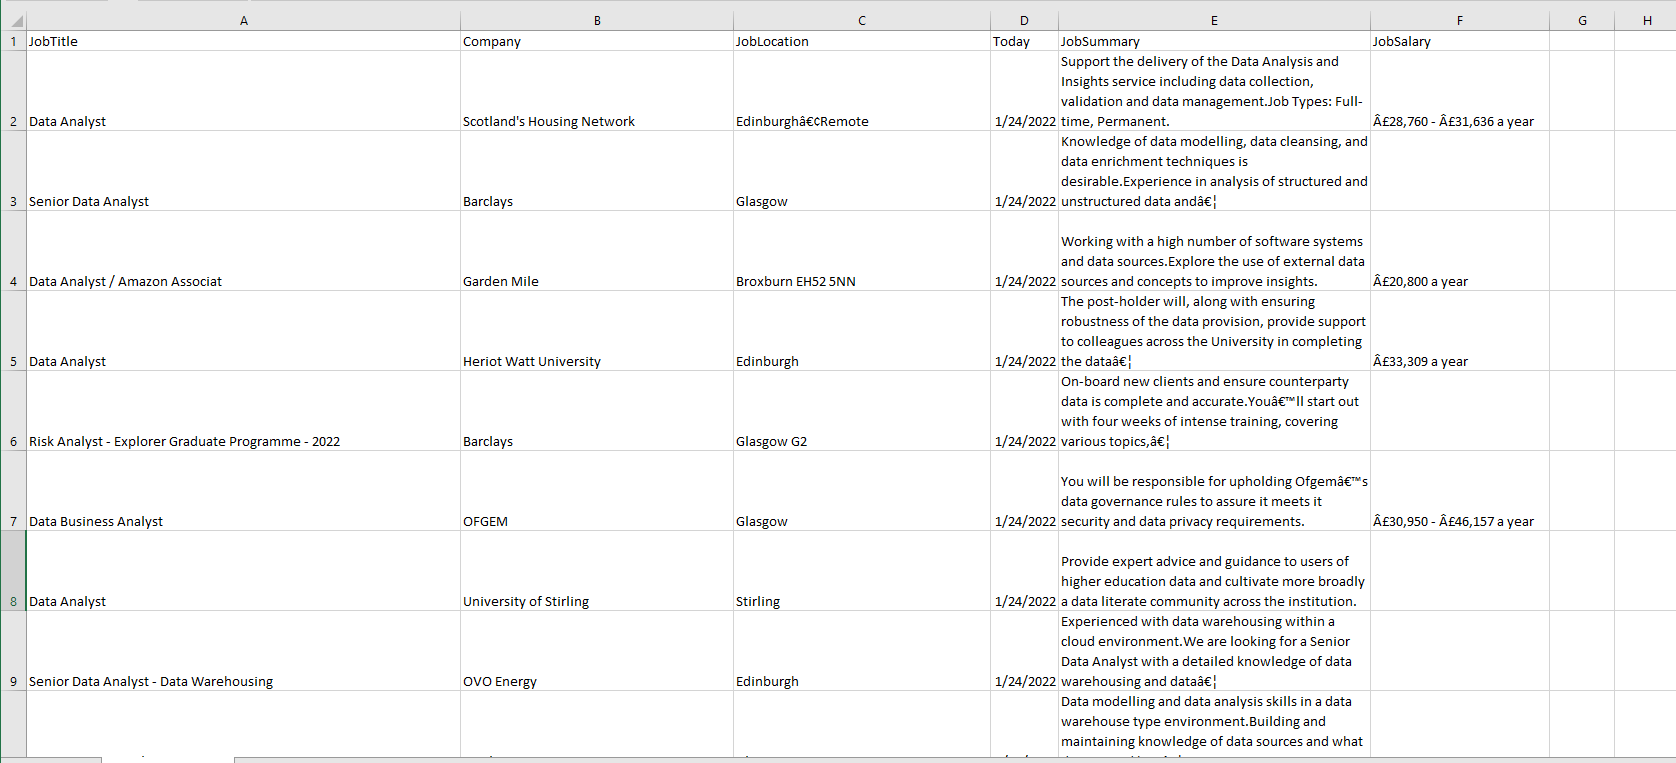

In [47]:
from IPython.display import Image
Image(filename=r'C:\Users\David\Pictures\csv_file.png')

In [31]:
# Importing the CSV file generated to SQL Server for analysis.
# First, let's import the CSV to a Pandas Dataframe.


data = pd.read_csv ('C:/Users/David/Documents/Python Scripts/job_search_results.csv') 
df = pd.DataFrame(data)

print(df.head())

                                            JobTitle  \
0                                       Data Analyst   
1                                Senior Data Analyst   
2                     Data Analyst / Amazon Associat   
3                                       Data Analyst   
4  Risk Analyst - Explorer Graduate Programme - 2022   

                      Company        JobLocation       Today  \
0  Scotland's Housing Network   Edinburgh•Remote  2022-01-24   
1                    Barclays            Glasgow  2022-01-24   
2                 Garden Mile  Broxburn EH52 5NN  2022-01-24   
3      Heriot Watt University          Edinburgh  2022-01-24   
4                    Barclays         Glasgow G2  2022-01-24   

                                          JobSummary                 JobSalary  
0  Support the delivery of the Data Analysis and ...  £28,760 - £31,636 a year  
1  Knowledge of data modelling, data cleansing, a...                       NaN  
2  Working with a high number of so

In [32]:
# Installing the pyodbc library.

!pip install pyodbc

In [34]:
# Verifying that the SQL Server driver is ready to use.

import pyodbc

pyodbc.drivers()

['SQL Server',
 'SQL Server Native Client 11.0',
 'ODBC Driver 17 for SQL Server',
 'SQL Server Native Client RDA 11.0',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)']

In [35]:
# Let's now connect Python to SQL Server. The Server name is 'DESKTOP-05EN5RK\SQLEXPRESS' and the database name is 'Job_Scraper'

conn = pyodbc.connect('DRIVER={SQL Server};'
                      'Server=DESKTOP-05EN5RK\SQLEXPRESS;'
                      'Database=Job_Scraper;'
                      'TRUSTED_CONNECTION=yes;')

In [36]:
cursor = conn.cursor()

In [42]:
# I was receiving the following error when trying to insert the data into the Table : "The supplied value is not a valid instance of data type float".
# After trying a few things here and there, replacing the nan values with zeros solved the problem.

df = df.fillna(0)

In [43]:
# Next, let's add the syntax to create the table in SQL Server. This table will be used to store the imported data from the CSV file.

cursor.execute('''
		CREATE TABLE scraped_jobs (
			JobTitle varchar(200),
			Company varchar(50),
			JobLocation nvarchar(50),
			Today date,
            JobSummary varchar(300),
            JobSalary nvarchar (100))
               ''')

In [44]:
# Inserting the DataFrame Data into the Table

for row in df.itertuples():
    cursor.execute('''
                INSERT INTO scraped_jobs (JobTitle, Company, JobLocation, Today, JobSummary, JobSalary)
                VALUES (?,?,?,?,?,?)
                ''',
                row.JobTitle, 
                row.Company,
                row.JobLocation,
                row.Today,
                row.JobSummary,
                row.JobSalary
                )
conn.commit()



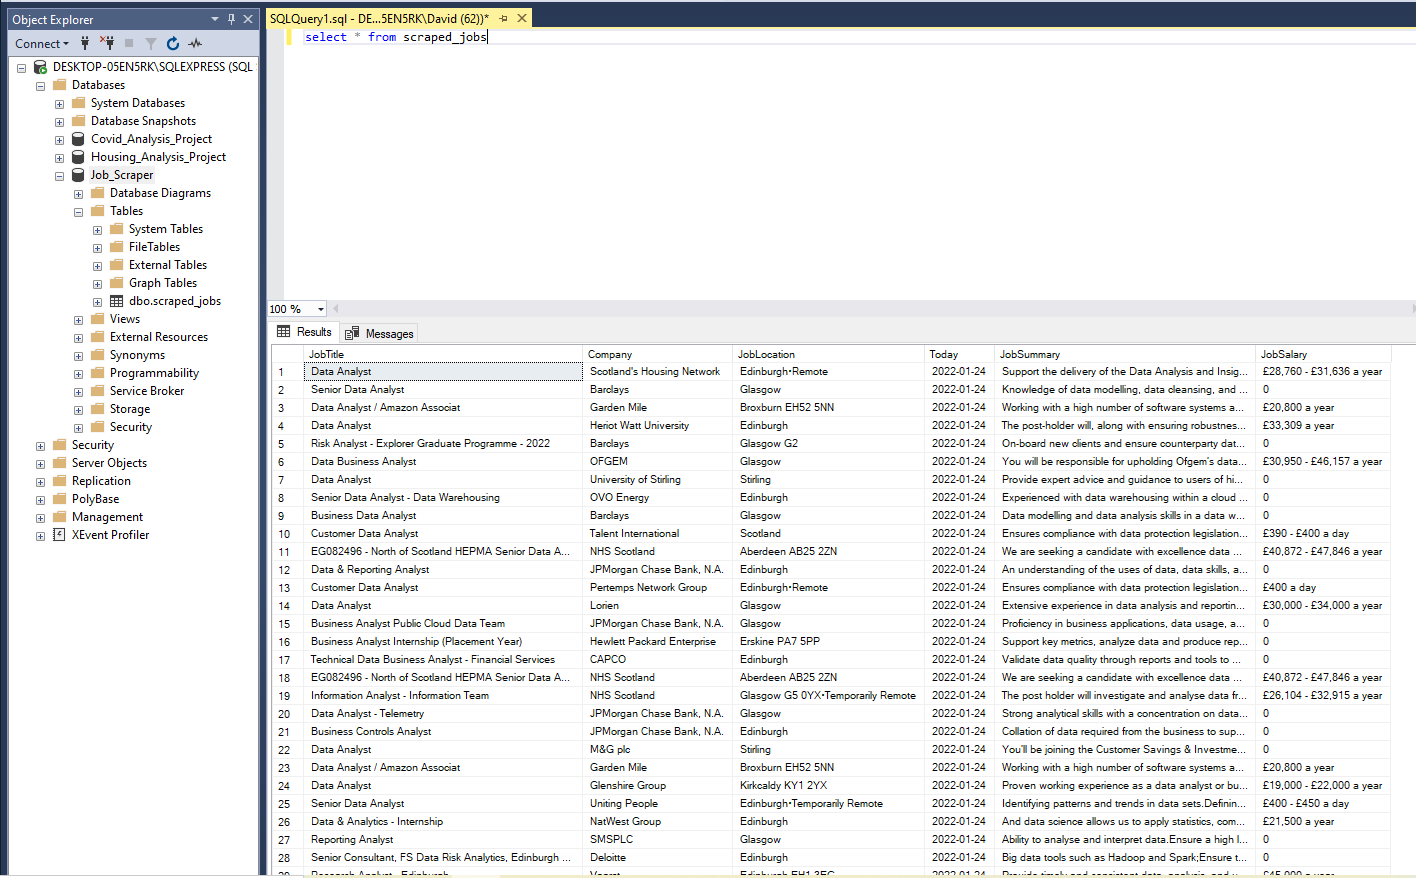

In [48]:
# Ran a test on SQL Server to check that the values had been inserted into the Table.

from IPython.display import Image
Image(filename=r'C:\Users\David\Pictures\SQL_server.png')